# Analysis of chemical similarity in `python` using `rdkit`

This notebook shows simple examples of finding and comparing the chemical [fingerprints](http://rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf) of molecular structures using [`rdkit`](http://www.rdkit.org/docs/GettingStartedInPython.html).



### Required libraries and modules


In [1]:
# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

# scipy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as hc

# seaborn -- for better looking plots
import seaborn as sns

# pandas 
import pandas as pd

# rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors

## Clustering molecules by fingerprint

In [2]:
smiles_list = ['CC', 'CCC', 'CCO', 'c1ccccc1', '[Na+].[Cl-]', '[Na+].[O-]C(=O)C', 'c1ccsc1', 'CC(O)=O']
names_list = ['ethane', 'propane', 'ethanol', 'benzene', 'sodium chloride', 'sodium acetate', 'thiophene', 'acetic acid']

mols = []
fingerprints = []

for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    mols.append(mol)

fingerprint_mat = np.vstack(np.asarray(rdmolops.RDKFingerprint(mol, fpSize = 2048), dtype = 'bool') for mol in mols)

In [3]:
dist_mat = pdist(fingerprint_mat, 'jaccard')

dist_df = pd.DataFrame(squareform(dist_mat), index = smiles_list, columns= smiles_list)

dist_df

,CC,CCC,CCO,c1ccccc1,[Na+].[Cl-],[Na+].[O-]C(=O)C,c1ccsc1,CC(O)=O
CC,0.000000,0.500,0.666667,1.00,1,0.857143,1.0,0.857143
CCC,0.500000,0.000,0.750000,1.00,1,0.875000,1.0,0.875000
CCO,0.666667,0.750,0.000000,1.00,1,0.571429,1.0,0.571429
c1ccccc1,1.000000,1.000,1.000000,0.00,1,0.960000,0.8,0.960000
[Na+].[Cl-],1.000000,1.000,1.000000,1.00,0,1.000000,1.0,1.000000
[Na+].[O-]C(=O)C,0.857143,0.875,0.571429,0.96,1,0.000000,1.0,0.000000
c1ccsc1,1.000000,1.000,1.000000,0.80,1,1.000000,0.0,1.000000
CC(O)=O,0.857143,0.875,0.571429,0.96,1,0.000000,1.0,0.000000


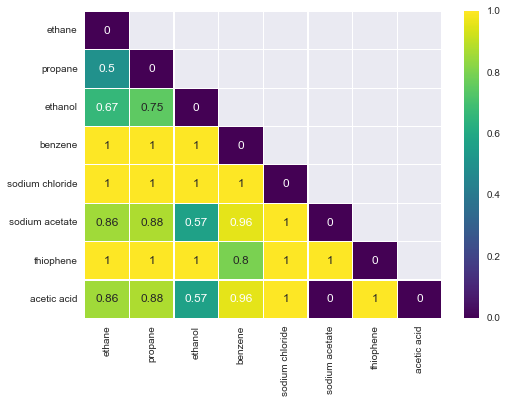

In [4]:
# set a mask so that only the lower-triangular part of the distance matrix is plotted
mask = np.zeros_like(dist_df, dtype = 'bool')
mask[np.triu_indices_from(mask, k = 1)] = True

# make the plot
sns.heatmap(dist_df, 
            mask=mask, 
            annot=True,
            cmap = cm.viridis,
            linewidths = 0.25,
            xticklabels=names_list,
            yticklabels=names_list
           )

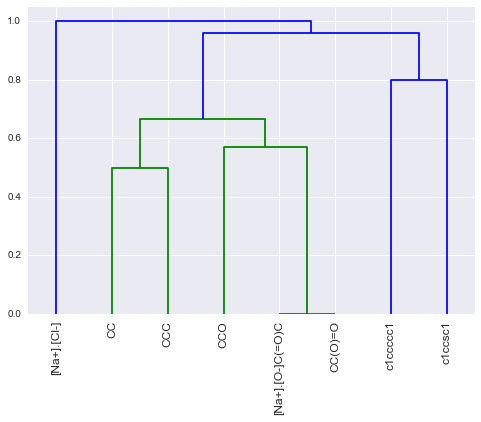

In [5]:
# use the distance matrix to hierarchically cluster the results
z = hc.linkage(dist_mat)
dendrogram = hc.dendrogram(z, labels=dist_df.columns, leaf_rotation=90)
plt.show()

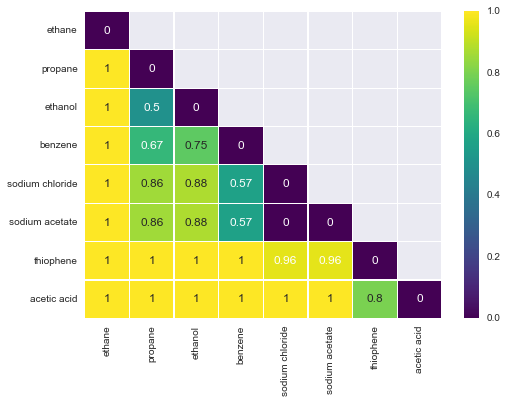

In [6]:
# find the order of leaves in the clustering results
new_order = dendrogram['ivl']

# reorder both rows and columns according to the clustering order
reordered_dist_df = dist_df[new_order].reindex(new_order)

# plot again
sns.heatmap(reordered_dist_df, 
            mask=mask, 
            annot=True, 
            cmap = cm.viridis, 
            linewidths = 0.25,
            xticklabels=names_list,
            yticklabels=names_list,
            )

## Plotting the fingerprint and distance matrices for various fingerprint sizes

In [7]:
def calc_fingerprint_mat(mols, fingerprint_size, show_plot=True):
    # Given a list of rdkit molecules of length m, and a fingerprint size n, calculate a m-by-n fingerpint matrix
    # :param:    mols               list of rdkit molecules
    # :param:    fingerprint_size   integer, must be a power of 2 for results to be meaningful
    # :param:    show_plot          boolean, whether to show the plots
    # :return:   fingerprint_mat    a boolean matrix of size m-by-fingerprint_size
    
    # calculate fingerprint matrix
    fp_tuple = (np.asarray(rdmolops.RDKFingerprint(mol, fpSize = fingerprint_size), dtype = 'bool') for mol in mols)
    fingerprint_mat = np.vstack(fp_tuple)
    
    if show_plot:
        f, axes = plt.subplots(1, 2, figsize = (12, 4))
    
        # construct fingerprint matrix plot
        sns.heatmap(fingerprint_mat, 
                    cmap = cm.viridis,
                    yticklabels=names_list,
                    ax = axes[0]
                   )
        axes[0].set_title('Fingerprint matrix with size %s' % fingerprint_size)
    
    # construct distance matrix
    dist_mat = pdist(fingerprint_mat, 'jaccard')
    dist_df = pd.DataFrame(squareform(dist_mat), 
                           index = smiles_list, 
                           columns = smiles_list)
    
    # plot distance matrix
    if show_plot:
        mask = np.zeros_like(dist_df, dtype = 'bool')
        mask[np.triu_indices_from(mask, k = 1)] = True

        # make the plot
        ax2 = sns.heatmap(dist_df, 
                    mask=mask, 
                    annot=True,
                    cmap = cm.viridis,
                    linewidths = 0.25,
                    xticklabels=names_list,
                    yticklabels=names_list,
                    ax = axes[1]
                   )
        axes[1].set_title('distance matrix with size %s' % fingerprint_size)

   
    return fingerprint_mat

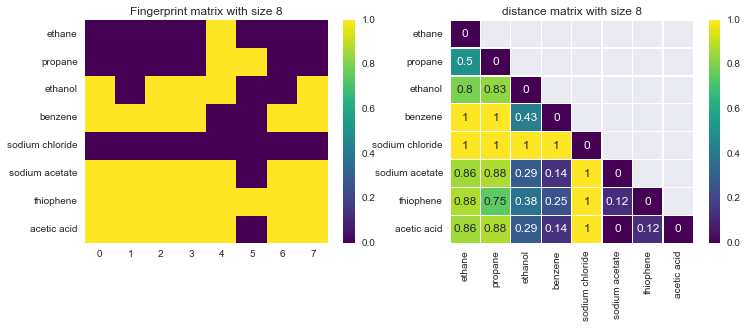

In [8]:
foo = calc_fingerprint_mat(mols, fingerprint_size=8)

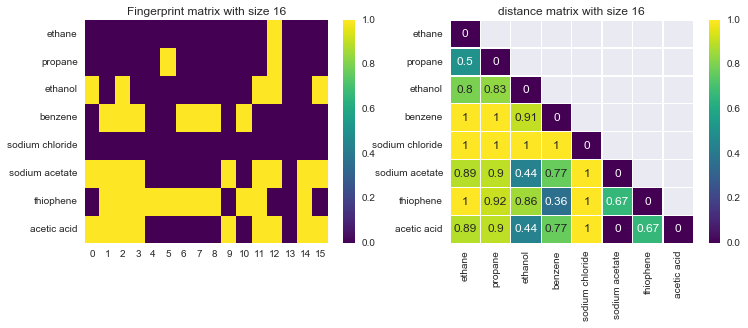

In [9]:
foo = calc_fingerprint_mat(mols, fingerprint_size=16)

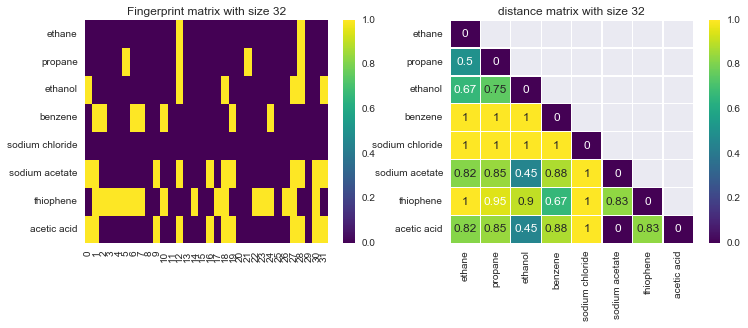

In [10]:
foo = calc_fingerprint_mat(mols, fingerprint_size=32)

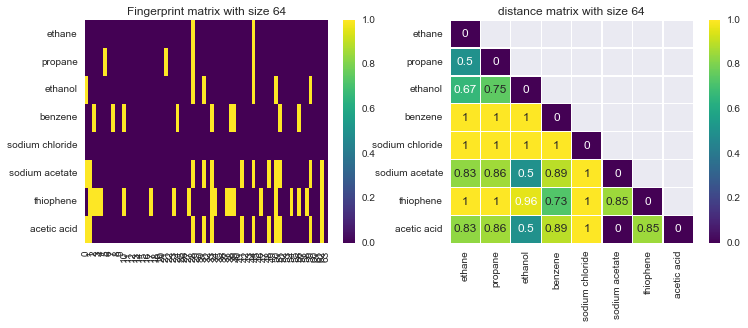

In [11]:
foo = calc_fingerprint_mat(mols, fingerprint_size=64)

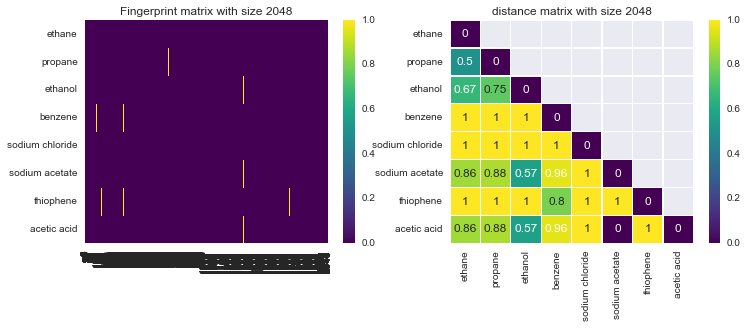

In [12]:
foo = calc_fingerprint_mat(mols, fingerprint_size=2048)